Finding y_thresh:  55%|█████████████▊           | 11/20 [00:05<00:04,  2.00it/s]

hit, miss, len(cache_dict) : 5 555 520
prediction.shape, y.shape, dist.shape, len(count_CS) : (15, 8192) (1, 8192) (15,) 6


Finding y_thresh:  30%|███████▊                  | 6/20 [00:05<00:12,  1.15it/s]


KeyboardInterrupt: 

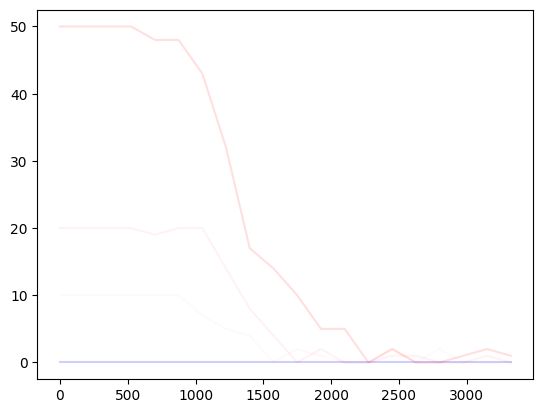

In [3]:
import glob 
import numpy as np
from tqdm import tqdm 
from smartprint import smartprint as sprint
from scipy.spatial import minkowski_distance_p
import random
import matplotlib.pyplot as plt


# compute CSR 
def compute_criticality_smooth(model_predict, training_data_folder, y_thresh=30, tnl=8, N=1000, \
                                  case="default", PM=True):
    """
    tnl: temporal_neighbour_limit 
    model_predict = model.predict    
    case: ["mean", "default", "max", "ratios", "min", "fractional"]
    PM: Perfect model
    """
    assert case in ["mean", "default", "max", "ratios", "min", "fractional"]
    count_CS = []
    cache_dict = {} # to reduce the number of file reads 
    hit, miss = 0, 0 
    filenames = glob.glob(training_data_folder + "/*.npy")
    filenames = [f for f in filenames if "_x" in f]
    
    range_of_fnames = list(range(tnl+1, len(filenames)-tnl))
    random.shuffle(range_of_fnames)
    
    
    total_count = 0 
    for i in (range_of_fnames[:N]): #, desc="computing CSR for training dataset"):
        total_count += 1 
        
        file = filenames[i]
        n = str(i) 
        if int(n) in cache_dict:
            x,y = cache_dict[int(n)]
            hit += 1 
        else:
            x = np.load(training_data_folder + "/"+ n +"_x" + ".npy") 
            y = np.load(training_data_folder + "/"+ n +"_y" + ".npy") 
            cache_dict[int(n)] = x,y
            miss += 1 

        neighbours_x = []        
        neighbours_y = []

        for j in range(-tnl, tnl):
            neigh = int(n) + j
            if j==0:
                continue
            if neigh in cache_dict:
                x_hat, y_hat = cache_dict[neigh]
                hit += 1
            else:
                x_hat = np.load(training_data_folder + "/"+ str(neigh) + "_x" + ".npy") 
                y_hat = np.load(training_data_folder + "/"+ str(neigh) + "_y" + ".npy")
                cache_dict[neigh] = x_hat, y_hat
                miss += 1 
                
            x_hat = x_hat.reshape((-1, x.shape[0], x.shape[1], x.shape[2]))
            x_hat = np.moveaxis(x_hat, [0, 1, 2, 3], [0, 2, 3, 1])[..., np.newaxis]
            
            y_hat = y_hat.reshape((-1, x.shape[0], x.shape[1], x.shape[2]))
            y_hat = np.moveaxis(y_hat, [0, 1, 2, 3], [0, 2, 3, 1])[..., np.newaxis]

            neighbours_x.append(x_hat)            
            neighbours_y.append(y_hat)
        
        if PM:
            prediction = (np.vstack(tuple(neighbours_y)))
        else: 
            prediction = model_predict(np.vstack(tuple(neighbours_x)))
            
        x = x.reshape((-1, x.shape[0], x.shape[1], x.shape[2]))
        x = np.moveaxis(x, [0, 1, 2, 3], [0, 2, 3, 1])[..., np.newaxis]        
        y = y.reshape((-1, y.shape[0], y.shape[1], y.shape[2]))
        y = np.moveaxis(y, [0, 1, 2, 3], [0, 2, 3, 1])[..., np.newaxis]
        
        a,b,c,d = prediction.shape[1], prediction.shape[2], prediction.shape[3], prediction.shape[4]
        prediction = prediction.reshape((-1, a*b*c*d))
        y = y.reshape((-1, a*b*c*d))

        dist = minkowski_distance_p(prediction, y, np.inf)

#         sprint (prediction.shape, y.shape, x.shape, x_hat.shape, y_hat.shape)

        if case == "mean":
            count_CS.append(np.mean(dist))
        elif case == "default":
            if np.any(dist > y_thresh):            
                count_CS.append(x)
        elif case == "fractional":
            count_CS.append((dist>y_thresh).sum()/dist.shape[0])                
        elif case == "max":
            count_CS.append(np.max(dist))
        elif case == "min":
            count_CS.append(np.min(dist))
        elif case == "ratios":

            x_neighbours = (np.vstack(tuple(neighbours_x)))
            x_neighbours = x_neighbours.reshape((-1, a*b*c*d))
            x = x.reshape((-1, a*b*c*d))
            distX = minkowski_distance_p(x_neighbours, x, np.inf) 
            ratio = dist/distX
            count_CS.append(np.sum(ratio))
            
        del cache_dict[int(n)-tnl] # no need to retain the files which have already been read 
        
        if np.random.rand() < 0.0005 : 
            sprint (hit, miss, len(cache_dict))
            sprint (prediction.shape, y.shape, dist.shape, len(count_CS))
    if case in ["mean", "ratios", "max", "min", "fractional"]:
        return (count_CS)
    elif case in ["default"]:
        return len(count_CS)


def determine_y_thresh_by_maximising_variance_around_mean(max_dist, N, method):
    std = {}
    mean = {}
    count = 1 
    for i in tqdm(np.arange(0, max_dist, abs(0-max_dist)/20), desc="Finding y_thresh"):
        l = compute_criticality_smooth("dummymodel", "training_data_8_4_8", y_thresh=i, \
                                       tnl=8, N=N, case=method, PM=True)
        std[i] = np.std(l)
        mean[i] = np.mean(l)
#         if count % 2==0:
#             plt.plot( list(std.keys()), list(std.values()) , label="var")
#             plt.plot( list(mean.keys()), list(mean.values()) , label="mean")
#             plt.legend()
#             plt.show()
        count += 1 
#     sprint (std)
    return (std), mean
    
# mean_thresh, std_thresh, max_thresh, n_required_to_converge, percent_diff = estimate_y_thresh\
#                                                     (model.predict, "training_data_8_4_8", tnl=8)
# sprint (mean_thresh, std_thresh, max_thresh, n_required_to_converge, percent_diff)
for method in ["default", "fractional"]:
    for i in [10, 20, 50, 100, 200, 400]:
        var_dict, mean_dict = determine_y_thresh_by_maximising_variance_around_mean(max_dist=3500, \
                                                                                    N = i, method = method) 
        # sprint (var_dict)
        # plt.show()
        plt.plot( list(var_dict.keys()), list(var_dict.values()) , label="var@" + str(i) + "points",\
                 color="blue",alpha=i/400)
        plt.plot( list(mean_dict.keys()), list(mean_dict.values()) , label="mean@" + str(i) + " points", \
                 color="red", alpha=i/400)
    plt.legend(fontsize=6)
    plt.xlabel(r"y_thresh")
    plt.ylabel(r"Complexity metric "+ method)
    plt.show()

# sprint ()
        
    
    
